# DeiT Training

In [1]:
import tarfile
from scipy.io import loadmat
import pandas as pd
import os
import shutil
import torch
from torchvision.datasets import ImageFolder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
import numpy as np
import time
import copy
import matplotlib.pyplot as plt

In [2]:
## Extract from tar file
# import tarfile
# file = tarfile.open("102segmentations.tgz")
# file.extractall('102flowersSegmentations')
# file.close()

## Load mat files
imagelabels = loadmat('imagelabels.mat')
# print(imagelabels)

setid = loadmat('setid.mat')
# print(setid)

## Generate labels df
df_labels = pd.DataFrame(imagelabels['labels'])
df_labels = df_labels.T
df_labels['image_id'] = df_labels.index +1 # rename the column such that it is image_id and labels
df_labels.set_index('image_id', inplace=True) # drop index by making image_id as index
df_labels.columns = ['labels'] # rename the column such that it is image_id and labels

# Generate train, test, validation df
df_setid_trnid = pd.DataFrame(setid['trnid'])
df_setid_valid = pd.DataFrame(setid['valid'])
df_setid_tstid = pd.DataFrame(setid['tstid'])

# Transpose the dataframes
df_setid_trnid = df_setid_trnid.T
df_setid_valid = df_setid_valid.T
df_setid_tstid = df_setid_tstid.T

## DEBUG
# print(df_setid_trnid.shape)
# print(df_setid_valid.shape)
# print(df_setid_tstid.shape)

# Create images df
image_folder = '102flowersSegmentations/segmim'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
df_images = pd.DataFrame(image_files, columns=['image_filename'])
df_images['image_id'] = df_images['image_filename'].str.extract(r'(\d+)').astype(int)

# Merge the dataframes
df_image_labels = df_images.merge(df_labels, on='image_id', how='left') # merge images and labels




In [3]:
# train, validation and test split
for id in df_setid_trnid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'train'

for id in df_setid_valid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'valid'

for id in df_setid_tstid[0]:
    df_image_labels.loc[df_image_labels['image_id'] == id, 'set'] = 'test'

# df_image_labels['set'].value_counts() # DEBUG

df_image_labels.to_csv('image_labels.csv', index=False) # save the dataframe to csv

## Sort into classes
num_classes = df_image_labels['labels'].nunique()
print("Number of classes: ", num_classes)
df_train_distribution = df_image_labels['labels'].value_counts().reset_index() # put information in a df
df_train_distribution.columns = ['class', 'count']
df_train_distribution = df_train_distribution.sort_values('count', ascending=False) # sort by class from 1 to 102

## create a folder for each class
# comment out if the folder already exists

# Create a new directory to store the class folders 
# os.makedirs('102flowers_segmen_split')

# Create a new directory to store the class folders 
# os.makedirs('102flowers_segmen_split/train')
# os.makedirs('102flowers_segmen_split/valid')
# os.makedirs('102flowers_segmen_split/test')

# split based on set in the csv
# for index, row in df_image_labels.iterrows():
#     image_filename = row['image_filename']
#     label = row['labels']
#     set = row['set']
#     src = os.path.join('102flowersSegmentations/segmim', image_filename)
#     dst = os.path.join('102flowers_segmen_split', set, str(label))
#     os.makedirs(dst, exist_ok=True)
#     shutil.copy(src, dst)



Number of classes:  102


In [4]:
# check if cuda is available
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


train_folder = '102flowers_segmen_split/train'
valid_folder = '102flowers_segmen_split/valid'
test_folder = '102flowers_segmen_split/test'

# create datasets
train_dataset = ImageFolder(train_folder) 
valid_dataset = ImageFolder(valid_folder)
test_dataset = ImageFolder(test_folder)

True
cuda


In [5]:
# create data generators
train_datagen = ImageDataGenerator( # create a data generator for data augmentation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

valid_datagen = ImageDataGenerator(rescale=1./255) # rescale the images

test_datagen = ImageDataGenerator(rescale=1./255)

# Define the transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create train and validation datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='102flowers_segmen_split/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(root='102flowers_segmen_split/valid', transform=valid_transforms)

# Create dataloaders for train and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Update dataloaders in a dictionary
dataloaders = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

# Update dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset)
}


## Mixup
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


## DeiT

In [6]:

from transformers import DeiTForImageClassification

model_deit = DeiTForImageClassification.from_pretrained(
    'facebook/deit-base-distilled-patch16-224',
    num_labels=102
)


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def train_model_transformer(model, criterion, optimizer, scheduler, num_epochs, patience):
    start = time.time()

    early_stopping = EarlyStopping(patience=patience, delta=0)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    accuracy_history = {'train': [], 'valid': []}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Apply mixup in the training phase only
                if phase == 'train':
                    inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)
                    outputs = model(inputs)
                    logits = outputs.logits  # Extract logits from the ImageClassifierOutput
                    loss = mixup_criterion(criterion, logits, labels_a, labels_b, lam)
                else:
                    outputs = model(inputs)
                    logits = outputs.logits  # Extract logits from the ImageClassifierOutput
                    loss = criterion(logits, labels)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    _, preds = torch.max(logits, 1)

                    # Calculate loss with mixup
                    if phase == 'train':
                        loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
                    else:
                        loss = criterion(logits, labels)  # Normal loss in validation

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running loss
                running_loss += loss.item() * inputs.size(0)

                # Calculate correct predictions differently based on phase
                if phase == 'train':
                    running_corrects += (lam * preds.eq(labels_a).sum().float() + (1 - lam) * preds.eq(labels_b).sum().float()).item()
                else:
                    running_corrects += (preds == labels).sum().item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            accuracy_history[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping check in the validation phase
            if phase == 'valid':
                early_stopping(epoch_loss, model)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

                if early_stopping.early_stop:
                    print("Early stopping triggered")
                    model.load_state_dict(early_stopping.get_best_model_weights())
                    return model, accuracy_history

        print()

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, accuracy_history

# define early stopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss  # We use -val_loss because we want to minimize loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

    def get_best_model_weights(self):
        return self.best_model_wts


In [8]:
def load_deit(num_frozen_layers):
    model = DeiTForImageClassification.from_pretrained(
        'facebook/deit-base-distilled-patch16-224',
        num_labels=102
    )

    # Freeze layers
    layers_to_freeze = list(model.children())[:num_frozen_layers]
    for layer in layers_to_freeze:
        for param in layer.parameters():
            param.requires_grad = True

    return model.to(device)
    

# Freeze all layers except the last one
model_deit = load_deit(11)





Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0/29
----------


c:\Users\alici\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\deit\modeling_deit.py:259: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


train Loss: 4.6457 Acc: 0.0305
valid Loss: 4.1654 Acc: 0.1824

Epoch 1/29
----------
train Loss: 3.8488 Acc: 0.1850
valid Loss: 2.4965 Acc: 0.5108

Epoch 2/29
----------
train Loss: 2.9478 Acc: 0.4064
valid Loss: 1.6262 Acc: 0.7147

Epoch 3/29
----------
train Loss: 2.4312 Acc: 0.5275
valid Loss: 1.2791 Acc: 0.7686

Epoch 4/29
----------
train Loss: 2.1895 Acc: 0.5788
valid Loss: 1.1054 Acc: 0.8137

Epoch 5/29
----------
train Loss: 2.0298 Acc: 0.5994
valid Loss: 0.9384 Acc: 0.8235

Epoch 6/29
----------
train Loss: 1.8726 Acc: 0.6239
valid Loss: 0.8498 Acc: 0.8353

Epoch 7/29
----------
train Loss: 1.6694 Acc: 0.6755
valid Loss: 0.7947 Acc: 0.8471

Epoch 8/29
----------
train Loss: 1.6816 Acc: 0.6508
valid Loss: 0.7718 Acc: 0.8569

Epoch 9/29
----------
train Loss: 1.5789 Acc: 0.6782
valid Loss: 0.7501 Acc: 0.8647

Epoch 10/29
----------
train Loss: 1.6394 Acc: 0.6599
valid Loss: 0.7356 Acc: 0.8696

Epoch 11/29
----------
train Loss: 1.5765 Acc: 0.6847
valid Loss: 0.7221 Acc: 0.8725



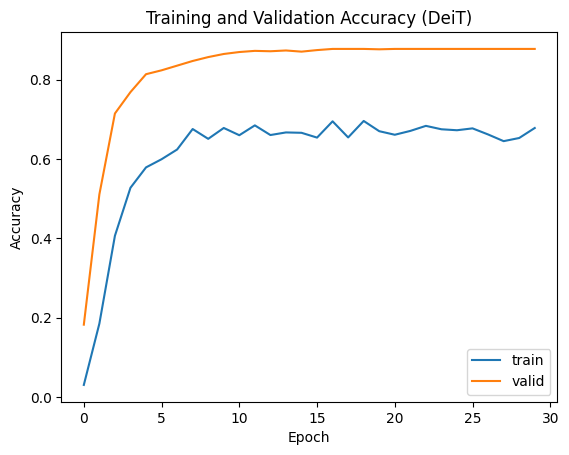

In [9]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_deit.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_deit.parameters()), lr=5e-5)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
deit_model, accuracy_history = train_model_transformer(model_deit, criterion, optimizer, exp_lr_scheduler, num_epochs=30, patience=5)

# Plot the training and validation accuracies
plt.plot(accuracy_history['train'], label='train')
plt.plot(accuracy_history['valid'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (DeiT)')
plt.legend()
plt.show()



In [ ]:
# save the model
torch.save(deit_model.state_dict(), 'model_deit(2).pth')
